# Facies classification using Machine Learning


In [1]:
import sklearn

print(sklearn.__version__)

0.19.1


In [2]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None
import seaborn as sns
# filename = '../facies_vectors.csv'
# training_data = pd.read_csv(filename)
# training_data[training_data['Well Name'] == 'STUART']
%config InlineBackend.figure_format = 'retina'

# type(training_data.Depth[2])


# load data

In [3]:
train_set_df=pickle.load(open('/Users/zhiliwei/onedrive/科研总览/new_dissertation/my dessertation/1.intro/train_set_df.pickled','rb'))

In [4]:
test_set_df=pickle.load(open('/Users/zhiliwei/onedrive/科研总览/new_dissertation/my dessertation/1.intro/test_set_df.pickled','rb'))

In [5]:
blind = test_set_df
training_data = train_set_df

In [6]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [7]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,4.503880,2907.308804,64.865990,0.658833,4.468016,13.215483,3.742031,1.519133,0.522110
std,2.474938,132.900638,30.174506,0.252715,5.252294,7.091140,0.840666,0.499701,0.285763
min,1.000000,2574.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2822.500000,44.710000,0.495000,1.667000,8.540000,3.150000,1.000000,0.278000
50%,4.000000,2933.000000,65.001000,0.639000,4.300000,12.050000,3.600000,2.000000,0.528000
75%,6.000000,3007.000000,79.340000,0.821000,7.562000,16.059000,4.300000,2.000000,0.767000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [8]:
#I changed the colors to match the paper for easier compare.
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histgram of the number of training examples for each facies class.

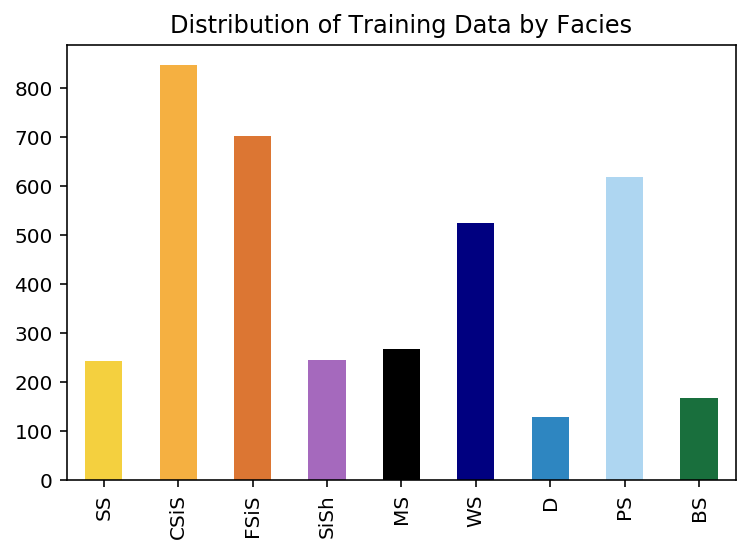

In [9]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)


facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

#light_rgb = colors.ListedColormap(facies_colors)
facies_counts.plot(kind='bar',color=facies_colors, 
                   
                   title='Distribution of Training Data by Facies')


## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [10]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,64.865990,0.658833,4.468016,13.215483,3.742031,1.519133,0.522110
std,30.174506,0.252715,5.252294,7.091140,0.840666,0.499701,0.285763
min,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,44.710000,0.495000,1.667000,8.540000,3.150000,1.000000,0.278000
50%,65.001000,0.639000,4.300000,12.050000,3.600000,2.000000,0.528000
75%,79.340000,0.821000,7.562000,16.059000,4.300000,2.000000,0.767000
max,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [11]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [12]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.1, random_state=42)

## Training the SVM classifier



In [13]:
from sklearn import svm

clf = svm.LinearSVC(random_state=42) 

# SVC grid search

In [14]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# # param_grid = {'svc__C': [1, 5, 10, 50],
# #               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
# # grid = GridSearchCV(clf, param_grid)

# # %time grid.fit(X_train, y_train)
# # print(grid.best_params_)

# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
# clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
#                    param_grid, cv=5, iid=False)
# clf = clf.fit(X_train, y_train)
# # print("done in %0.3fs" % (time() - t0))
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

Now we can train the classifier using the training set we created above.

In [15]:
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [16]:
predicted_labels = clf.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    15     6                                              21
     CSiS     5    58    21                                        84
     FSiS          27    42                             1          70
     SiSh           1          15           6     1     2          25
       MS           1           7          11     2     7          28
       WS                       4          32     3    21          60
        D                       1           1     8     8          18
       PS                       1          11     1    39     3    55
       BS                       1                       6     6    13

Precision  0.75  0.62  0.67  0.52  0.00  0.52  0.53  0.46  0.67  0.54
   Recall  0.71  0.69  0.60  0.60  0.00  0.53  0.44  0.71  0.46  0.57
       F1  0.73  0.66  0.63  0.56  0.00  0.53  0.48  0.56  0.55  0.55


/Users/zhiliwei/onedrive/科研总览/new_dissertation/my dessertation/3.SVM_code/CannedGeo_/classification_utilities.py:13: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')


In [18]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [19]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [20]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.574866
Adjacent facies classification accuracy = 0.925134


## Model parameter selection

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

In [21]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = False

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

The best accuracy on the cross validation error curve was achieved for `gamma = 1`, and `C = 10`.  We can now create and train an optimized classifier based on these parameters:

In [22]:
clf = svm.LinearSVC(class_weight='balanced', tol=1e-03,C=10, random_state=42)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.56
Optimized adjacent facies classification accuracy = 0.89


In [23]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    18     3                                              21
     CSiS    11    49    24                                        84
     FSiS     3    18    48                             1          70
     SiSh           1          16           5     2     1          25
       MS           1          11     3     6     4     2     1    28
       WS                       9     1    28     4    11     7    60
        D                       2                14     2          18
       PS                       2     1    10     5    25    12    55
       BS                                               3    10    13

Precision  0.56  0.68  0.67  0.40  0.60  0.57  0.48  0.56  0.33  0.59
   Recall  0.86  0.58  0.69  0.64  0.11  0.47  0.78  0.45  0.77  0.56
       F1  0.68  0.63  0.68  0.49  0.18  0.51  0.60  0.50  0.47  0.55


In [24]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    21                                                    21
     CSiS          84                                              84
     FSiS     3          66                             1          70
     SiSh           1          16           5     2     1          25
       MS           1                20           4     2     1    28
       WS                       9          44                 7    60
        D                       2                16                18
       PS                       2     1                52          55
       BS                                                    13    13

Precision  0.88  0.98  1.00  0.55  0.95  0.90  0.73  0.93  0.62  0.90
   Recall  1.00  1.00  0.94  0.64  0.71  0.73  0.89  0.95  1.00  0.89
       F1  0.93  0.99  0.97  0.59  0.82  0.81  0.80  0.94  0.76  0.89


## Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [25]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1071,1,B1 SH,SHANKLE,2842.0,52.720,0.590000,2.200,9.880,3.20000,1,0.367
2594,1,B4 SH,CROSS H CATTLE,2729.0,54.345,0.160168,1.400,16.200,2.97500,1,0.732
2600,1,B4 SH,CROSS H CATTLE,2732.0,61.969,0.157457,4.200,17.800,2.86300,1,0.625
2629,1,B4 SH,CROSS H CATTLE,2746.5,79.285,0.313234,5.100,14.750,2.84900,1,0.107
2551,1,B3 SH,CROSS H CATTLE,2708.0,68.186,0.519040,2.000,11.800,3.16200,1,0.540
...,...,...,...,...,...,...,...,...,...,...,...
1300,3,C SH,SHANKLE,2964.5,75.850,0.626000,1.800,21.045,2.90000,1,0.351
3920,3,B2 SH,CHURCHMAN BIBLE,3005.0,69.438,0.556000,-18.252,40.175,2.87900,1,0.417
1274,3,C SH,SHANKLE,2951.5,66.670,0.659000,10.700,14.420,3.20000,1,0.807
480,3,A1 SH,ALEXANDER D,2892.0,91.350,0.521000,7.400,15.330,3.13234,1,0.769


The label vector is just the `Facies` column:

In [26]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [27]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

Now we can transform this with the scaler we made before:

In [28]:
X_blind = scaler.transform(well_features)

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [29]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

In [30]:
y_pred
np.save('svm_ypred',y_pred)

Let's see how we did with the confusion matrix:

In [31]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.53
Optimized adjacent facies classification accuracy = 0.87


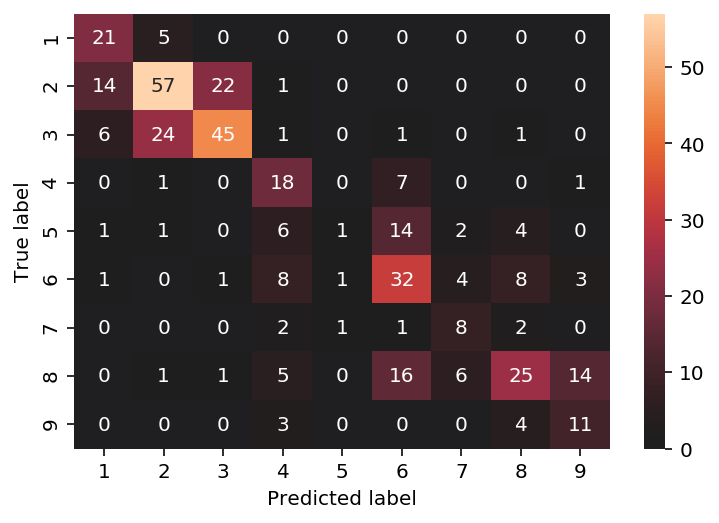

In [32]:
temp=['1','2','3','4','5','6','7','8','9']

sns.heatmap(cv_conf,annot=True, center=True,fmt='d',xticklabels=temp,yticklabels=temp)
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.show()

In [33]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    21     5                                              26
     CSiS    14    57    22     1                                  94
     FSiS     6    24    45     1           1           1          78
     SiSh           1          18           7                 1    27
       MS     1     1           6     1    14     2     4          29
       WS     1           1     8     1    32     4     8     3    58
        D                       2     1     1     8     2          14
       PS           1     1     5          16     6    25    14    68
       BS                       3                       4    11    18

Precision  0.49  0.64  0.65  0.41  0.33  0.45  0.40  0.57  0.38  0.54
   Recall  0.81  0.61  0.58  0.67  0.03  0.55  0.57  0.37  0.61  0.53
       F1  0.61  0.62  0.61  0.51  0.06  0.50  0.47  0.45  0.47  0.51


...but does remarkably well on the adjacent facies predictions. 

In [34]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    26                                                    26
     CSiS          93           1                                  94
     FSiS     6          69     1           1           1          78
     SiSh           1          18           7                 1    27
       MS     1     1                21           2     4          29
       WS     1           1     8          45                 3    58
        D                       2     1          11                14
       PS           1     1     5                      61          68
       BS                       3                            15    18

Precision  0.76  0.97  0.97  0.47  0.95  0.85  0.85  0.92  0.79  0.89
   Recall  1.00  0.99  0.88  0.67  0.72  0.78  0.79  0.90  0.83  0.87
       F1  0.87  0.98  0.93  0.55  0.82  0.81  0.81  0.91  0.81  0.88


In [35]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
#     print(logs)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

## K-fold cross validation

In [36]:
from sklearn.model_selection import KFold
#from sklearn.model_selection import KFold

kf = KFold(4, random_state=666)

In [37]:
print(kf)

KFold(n_splits=4, random_state=666, shuffle=False)
